# **Assignment 6**
# **Sunspots – magnetic field and temperature structure. Part II.**

### **Data Analysis for Space Weather | Instructor: Prof Podladchikova | April, 2021**
### **by Victoria Krivova, Polina Starodumova**

In [1]:
# Firstly, we install SunPy package
# !pip install sunpy

In [2]:
# After that, we import several libraries which will be used during the assignment implementation 
from astropy.io import fits
from astropy import units as u

In [390]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import numpy as np
import math
from matplotlib.colors import LogNorm
# from google.colab import files
import scipy.stats as stats
import matplotlib.mlab as mlab

In [4]:
import sunpy
import sunpy.map

In [267]:
# In the original Astropy package of units, there is no angstrom, however, it will be needed for FITS files to work 
# correctly, so we deifine the unit by ourselves
ANG = u.def_unit('ANG', 10**(-10) * u.m)
u.add_enabled_units([ANG]);

In [268]:
# Since we are working in Google Colab, we need to use the following function to upload the datasets
# uploaded = files.upload()

**Since this is the continuation of the Assignment 5, we will just copy the data importing parts as well as the algorithms to segment the sunspot into the umbra, penumbra and quite solar regions.**

In [304]:
# Continuum image of the Sun
data_1, header_1 = sunpy.io.fits.read('hmi.Ic_720s.20141219_230000_TAI.1.continuum_cal.fits')[0]
map_1 = sunpy.map.Map(data_1, header_1)

In [305]:
# Image of the line-of-site (LOS) magnetic field flux density
data_2, header_2 = sunpy.io.fits.read('hmi.M_720s.20141219_230000_TAI.1.magnetogram_cal.fits')[0]
map_2 = sunpy.map.Map(data_2, header_2)

In [306]:
# Let us extract the field of interest with the sunspot from the southern hemisphere
a = 2335
b = 2500
c = 1700
d = 1870

In [307]:
data_1_sunspot = data_1[c:d, a:b]
map_1_sunspot = sunpy.map.Map(data_1_sunspot, header_1)

data_2_sunspot = data_2[c:d, a:b]
map_2_sunspot = sunpy.map.Map(data_2_sunspot, header_1)

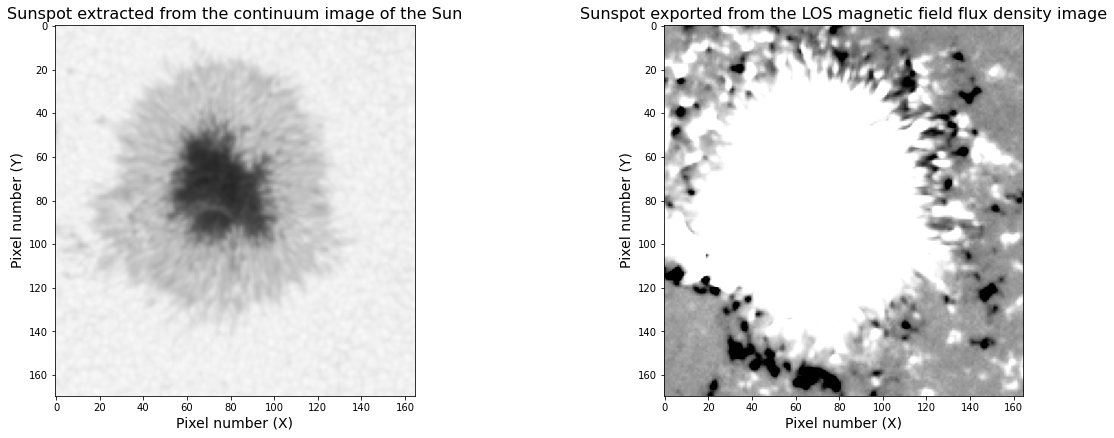

In [308]:
fig = plt.figure(figsize=(20, 15))

ax1 = fig.add_subplot(2,2,1)
ax1.set_xlabel('Pixel number (X)', **axis_font)
ax1.set_ylabel('Pixel number (Y)',  **axis_font)
ax1.imshow(data_1_sunspot, cmap='Greys_r', norm=colors.Normalize(vmin=0, vmax=64000))
ax1.set_title('Sunspot extracted from the continuum image of the Sun', **title_font)

ax2 = fig.add_subplot(2,2,2)
ax2.set_xlabel('Pixel number (X)', **axis_font)
ax2.set_ylabel('Pixel number (Y)',  **axis_font)
ax2.imshow(data_2_sunspot, cmap='Greys_r', norm=colors.Normalize(vmin=-100, vmax=100))
ax2.set_title('Sunspot exported from the LOS magnetic field flux density image', **title_font);

**We have already worked with this sunspot in the previous assignment. Now, we will analyze individually the total magnetic flux of the sunspot as a whole and its subparts obtained from the magnetic flux image as well as the mean intensity for the same subparts obtained from the continuum image. For that, we need to find the size of the pixel in centimeters by converting the given value in arcseconds:**

In [309]:
ang_resol = header_2['CDELT1']            # arcsec/pix - angular resolution of the pixel in arcseconds
arcsec_sun = header_2['RSUN_OBS']         # arcsec     - angular resolution of the Sun in arcseconds
R_sun = 696340                            # km         - radius of the Sun

In [310]:
cm_per_arc = R_sun / arcsec_sun * 100000  # сm/arcsec  - convertion of the arcseconds to the centimeters
cm_per_pix = cm_per_arc * ang_resol       # cm/pix     - linear resolution of the pixel in centimeters

**To calculate the total magnetic flux of the sunspot and its subparts, we need to (1) segment the ROI, (2) multiply the absolute value of the magnetic flux density in each pixel by the pixel area and finally (3) sum it up. The unit of the total magnetic flux will be ($G$ $\cdot$ $cm^2$) which is Maxwell (Mx).**

In [334]:
# Sunspot
magn_sunspot = np.copy(data_2[c:d, a:b])

for k in range (0, 170):
    for j in range (0, 165):
        if (magn_sunspot[k][j]) < 400:
            magn_sunspot[k][j] = 0
            
magn_flux = []

for k in range (0, 170):
    for j in range (0, 165):
        magn_flux.append(magn_sunspot[k][j] * cm_per_pix ** 2)

In [335]:
# Umbra
magn_umbra = np.copy(data_2[c:d, a:b])

x = magn_umbra.min()

for k in range (0, 170):
    for j in range (0, 165):
        if (magn_umbra[k][j]) < (2000 + x):
            magn_umbra[k][j] = 0
            
magn_flux_u = []

for k in range (0, 170):
    for j in range (0, 165):
        magn_flux_u.append(magn_umbra[k][j] * cm_per_pix ** 2)

In [336]:
# Penumbra
magn_penumbra = np.copy(data_2[c:d, a:b])

for k in range (0, 170):
    for j in range (0, 165):
        if (magn_penumbra[k][j]) < 400 or (magn_penumbra[k][j]) > (2000 + x):
            magn_penumbra[k][j] = 0
            
magn_flux_p = []

for k in range (0, 170):
    for j in range (0, 165):
        magn_flux_p.append(magn_penumbra[k][j] * cm_per_pix ** 2)

In [338]:
# Total magnetic flux
TMF = np.sum(np.array(magn_flux))  # Mx
print("The total magnetic flux of the sunspot under study is %.2e" % TMF, 'Mx.')

# Total magnetic flux (umbra)
TMF_u = np.sum(np.array(magn_flux_u))  # Mx
print("The total magnetic flux in the umbra region is %.2e" % TMF_u, 'Mx.')

# Total magnetic flux (penumbra)
TMF_p = np.sum(np.array(magn_flux_p))  # Mx
print("The total magnetic flux in the penumbra region is %.2e" % TMF_p, 'Mx.')

The total magnetic flux of the sunspot under study is 7.52e+21 Mx.
The total magnetic flux in the umbra region is 2.98e+21 Mx.
The total magnetic flux in the penumbra region is 4.53e+21 Mx.


**Here one may notice that the major portion of the magnetic flux of the sunspot is produced by the penumbra region. It is due to the fact that the total magnetic flux is proportional to the absolute value of the magnetic flux density and the area of the region and, if one recalls from the Assignment 5, the area of the penumbra is much higher than the one for the umbra.**

In [342]:
print('The fraction of the total magnetic flux in the umbra region to the total flux is approximately %.1f' 
      % (TMF_u/TMF*100), '%.')

The fraction of the total magnetic flux in the umbra region to the total flux is approximately 39.7 %.


**Thus, we see that the total magnetic flux is "splitted" between umbra/penumbra regions as approximately 40%/60%.**

**Now, we will use the continuum image of the Sun to calculate the mean values of the intensities for the three areas - umbra, penumbra, backround.**

In [348]:
# Umbra
int_umbra = np.copy(data_1[c:d, a:b])

for k in range (0, 170):
    for j in range (0, 165):
        if (int_umbra[k][j]) > 20000:
            int_umbra[k][j] = 0

In [351]:
# Penumbra
int_penumbra = np.copy(data_1[c:d, a:b])

for k in range (0, 170):
    for j in range (0, 165):
        if (int_penumbra[k][j]) < 20000 or (int_penumbra[k][j]) > 50000 :
            int_penumbra[k][j] = 0

In [355]:
# Background
int_back = np.copy(data_1[c:d, a:b])

for k in range (0, 170):
    for j in range (0, 165):
        if (int_back[k][j]) < 50000 :
            int_back[k][j] = 0

In [419]:
mean_int_u = np.sum(int_umbra) / np.count_nonzero(int_umbra)
print('The mean intensity for the umbra is %.0f' % (mean_int_u), 'units.')

mean_int_p = np.sum(int_penumbra) / np.count_nonzero(int_penumbra)
print('The mean intensity for the penumbra is %.0f' % (mean_int_p), 'units.')

mean_int_b = np.sum(int_back) / np.count_nonzero(int_back)
print('The mean intensity for the background region is %.0f' % (mean_int_b), 'units.')

The mean intensity for the umbra is 13025 units.
The mean intensity for the penumbra is 41121 units.
The mean intensity for the background region is 55767 units.


**Here we notice that the value of the mean intensity for the background (quite sun region) is significantly higher than the one for the umbra and slightly higher than the one for the penumbra - the brightness of the regions increases from the umbra to the background area. What's interesting for us is to get the ratios of the mean intensities of umbra and penumbra in comparison with the background value:**

In [364]:
F_u_b = mean_int_u/mean_int_b
F_p_b = mean_int_p/mean_int_b

print('The ratio of the umbra region intensity to the one for the quite area is %.2f' % F_u_b, ';')
print('The ratio of the penumbra region intensity to the one for the quite area is %.2f' % F_p_b, '.')

The ratio of the umbra region intensity to the one for the quite area is 0.23 ;
The ratio of the penumbra region intensity to the one for the quite area is 0.74 .


**Let us recall that the radiation flux 𝐹 emitted by a black body is proportional to the fourth power of its temperature (Stefan-Bolzmann law):**

$$F = \sigma T^4$$

**For simplicity, we assume that our measured continuum mean intensities are representative for the wavelength integrated flux 𝐹 emitted. Hence, we can estimate the temperature in the sunspot umbra and penumbra regions, knowing that the mean temperature of the quiet Sun is 𝑇 = 5772 K via the aforementioned formula:**

In [366]:
# The mean temperature of the quite Sun
T_b = 5772 # K

In [420]:
T_u = (F_u_b * T_b ** 4) ** (1/4)
print('The estimated temperature in the umbra region is %.0f' % T_u, 'K.')

T_p = (F_p_b * T_b ** 4) ** (1/4)
print('The estimated temperature in the penumbra region is %.0f' % T_p, 'K.')

The estimated temperature in the umbra region is 4013 K.
The estimated temperature in the penumbra region is 5349 K.


**As it was expected, the temperature in the epicenter of the sunspot (umbra) is less than the one for the penumbra and the mean temperature of the quite sun. It is because strong magnetic fields concentrated in the sunspots hamper the energy transport by convective gas motions from the solar interior to the photosphere and, thus, cooling the area.** 

**Let us import the SDO AIA images recorded in the filters centered at a wavelength of 193, 304 and 1700 Å and analyze what atmospheric layers they represent and what phenomena are observed on them:** 

In [376]:
data_193, header_193 = sunpy.io.fits.read('saia_00193_fd_20141219_223320.fts')[0]
data_304, header_304 = sunpy.io.fits.read('saia_00304_fd_20141219_223319.fts')[0]
data_1700, header_1700 = sunpy.io.fits.read('saia_01700_fd_20141219_223318.fts')[0]

**Firstly, let us recall the images we used for the analysis of the sunspots and the magnetic fluxes they produce:**

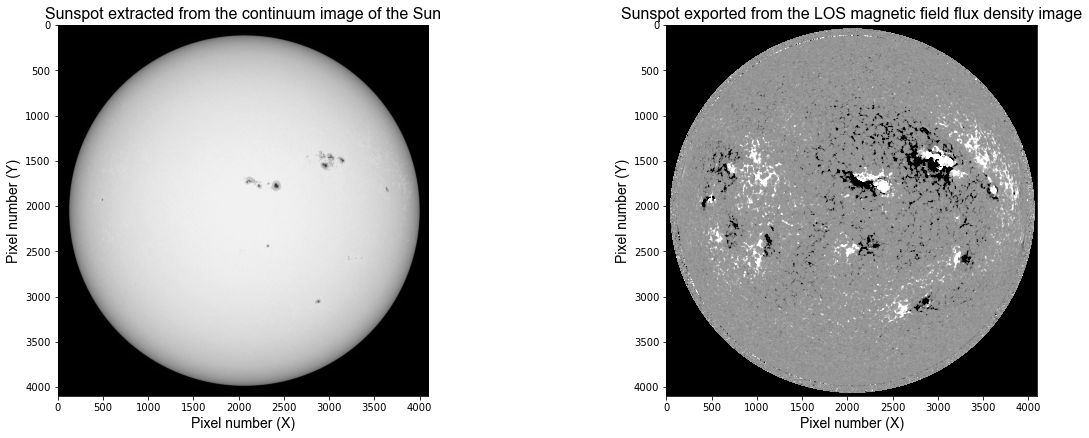

In [381]:
fig = plt.figure(figsize=(20, 15))

ax1 = fig.add_subplot(2,2,1)
ax1.set_xlabel('Pixel number (X)', **axis_font)
ax1.set_ylabel('Pixel number (Y)',  **axis_font)
ax1.imshow(data_1, cmap='Greys_r', norm=colors.Normalize(vmin=0, vmax=64000))
ax1.set_title('Sunspot extracted from the continuum image of the Sun', **title_font)

ax2 = fig.add_subplot(2,2,2)
ax2.set_xlabel('Pixel number (X)', **axis_font)
ax2.set_ylabel('Pixel number (Y)',  **axis_font)
ax2.imshow(data_2, cmap='Greys_r', norm=colors.Normalize(vmin=-100, vmax=100))
ax2.set_title('Sunspot exported from the LOS magnetic field flux density image', **title_font);

**And there let us plot the new images at different wavelengths:**

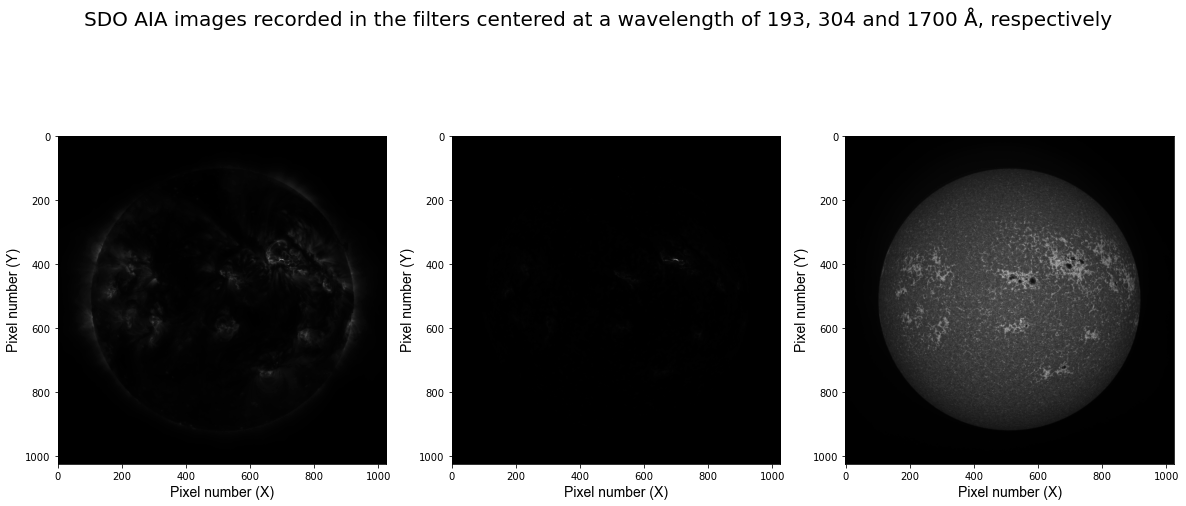

In [423]:
fig = plt.figure(figsize=(20, 15))

fig.suptitle("SDO AIA images recorded in the filters centered at a wavelength of 193, 304 and 1700 Å, respectively", 
             fontsize=20)

ax1 = fig.add_subplot(2,3,1)
ax1.set_xlabel('Pixel number (X)', **axis_font)
ax1.set_ylabel('Pixel number (Y)',  **axis_font)
ax1.imshow(data_193, cmap='Greys_r')
ax1.set_title('', **title_font)

ax2 = fig.add_subplot(2,3,2)
ax2.set_xlabel('Pixel number (X)', **axis_font)
ax2.set_ylabel('Pixel number (Y)',  **axis_font)
ax2.imshow(data_304, cmap='Greys_r')
ax2.set_title('', **title_font);

ax3 = fig.add_subplot(2,3,3)
ax3.set_xlabel('Pixel number (X)', **axis_font)
ax3.set_ylabel('Pixel number (Y)',  **axis_font)
ax3.imshow(data_1700, cmap='Greys_r')
ax3.set_title('', **title_font);

**Due to the fact that the variability of the emission in the corona is extremely high, it usually ranges over orders of magnitude in intensity. Thus, it is better to rescale the pixel values of the first two images to the logarithmic scale so that we could see more properly the structure on the image due to the higher contrast:**

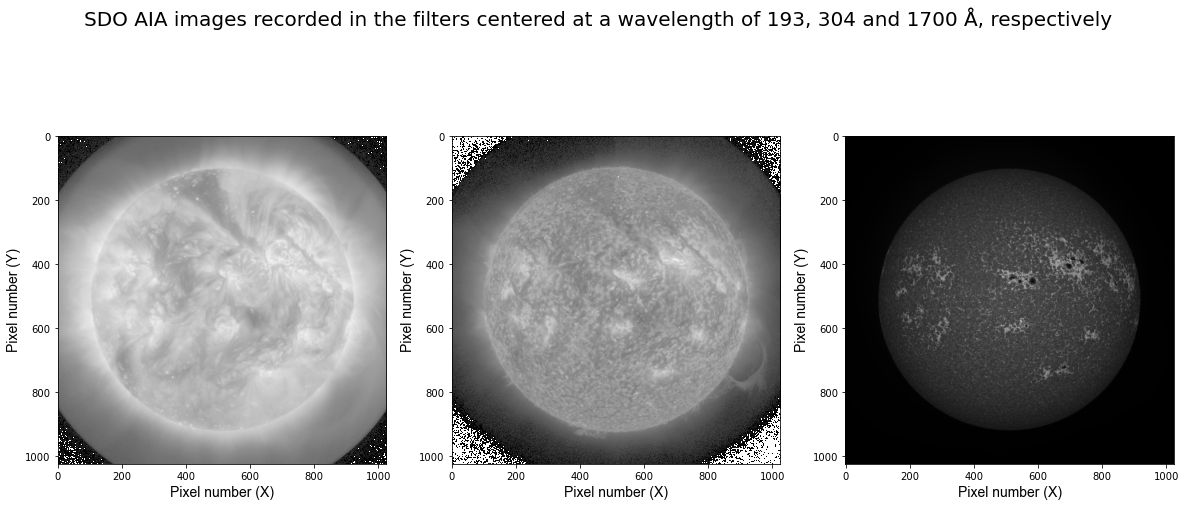

In [418]:
fig = plt.figure(figsize=(20, 15))

fig.suptitle("SDO AIA images recorded in the filters centered at a wavelength of 193, 304 and 1700 Å, respectively", 
             fontsize=20)

ax1 = fig.add_subplot(2,3,1)
ax1.set_xlabel('Pixel number (X)', **axis_font)
ax1.set_ylabel('Pixel number (Y)',  **axis_font)
ax1.imshow(data_193, cmap='Greys_r', norm=LogNorm())
ax1.set_title('', **title_font)

ax2 = fig.add_subplot(2,3,2)
ax2.set_xlabel('Pixel number (X)', **axis_font)
ax2.set_ylabel('Pixel number (Y)',  **axis_font)
ax2.imshow(data_304, cmap='Greys_r', norm=LogNorm())
ax2.set_title('', **title_font);

ax3 = fig.add_subplot(2,3,3)
ax3.set_xlabel('Pixel number (X)', **axis_font)
ax3.set_ylabel('Pixel number (Y)',  **axis_font)
ax3.imshow(data_1700, cmap='Greys_r')
ax3.set_title('', **title_font);

**The first image (193 A) represents the outer atmosphere of the Sun - the corona. Hot active regions, solar flares, coronal loops and coronal mass ejections appear bright. The dark areas correspond to the coronal holes - the places where very little radiation is emitted, although they are the main source of solar wind particles. The second image (304 A) typically represents the chromosphere of the Sun. On this image, one may distinguish mostly the plage regions (magnetic regions), and since they have higher temperature, they appear brighter. The third image (1700 A) shows mostly the upper photosphere/the transition region. The continuum and magnetic sun images also show the "structure" of the photosphere. Here we can see the sunspots and their dual structure. Moreover, if we zoom in the images, we will be able to see the solar faculae dispersed between the granules.**

**Learning log:** In this assignment, we mostly continued working with the preprocessed continuum and magnetic images of the Sun. As we did it in the previous assignment, we segmented the sunspot under study into three regions - umbra, penumbra and background. Then, we needed to calculate the total magnetic flux individually for each segment recalling that the values of the pixels from the magnetic image represent the magnetic flux density in CGS units of Gauss and that the headers of the FITs files include the angular resolution of the pixel which then shall be converted to the linear one via the known values for the Sun. The final values of the total magnetic fluxes turned out to be unexpectedly huge of the 21st order in magnitude. It was also noticed that, althought the mean magnetic flux density was the highest for the umbra (Assignment 5), the total magnetic flux is much higher for the penumbra since this parameter is proportional to the area of interest (and this area is much higher for the penumbra than for the umbra). The trend for the mean values of the intensities obtained from the continuum image of the Sun is an increasing one from the center of the sunspot to the quite regions. Once we got the ratios of the mean intensities with respect to the background intensity, we could estimate the temperatures of the umbra and penumbra regions via the Stefan-Bolzman law which states that the flux is proportional to the fourth power of the temperature - as a result, we had the temperatures of 4013 K for the umbra and 5349 K for the penumbra. It was expected since it is known that the temperature inside the sunspot is lower than the one for its surroundings because strong magnetic fields concentrated in the sunspots hamper the energy transport by convective gas motions from the solar interior to the photosphere and, thus, cooling the area. In the final part of the assignment, we needed to analyze the images of the Sun obtained at the same day but via three different filters with centers at 193, 304 and 1700 angstroms. It was noticed that the former two images were too dark to be analyzed visually, thus, we needed to add some contrast by rescaling the images to the logarithmic scale. Finally, we identified which atmospheric layers these images show - corona, chromosphere and the photosphere (with some features of the transition region) - and provided a description of which phenomena can be visually distinguished from these images. Some of the phenomena which were discussed during the lecture were not clearly indentified - especially on the image with the corona. 